In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyksc import ksc

In [2]:
filename = '/home/wagner/GitHub/curva_crescimento/projetos_concatenados/projetos_concatenados/akka.csv'

In [3]:
df = pd.read_csv(filename, usecols=['Commit', 'Date', 'Project', 'blank', 'code', 'comment', 'filename', 'language'])
df['Date'] = df.Date.apply(lambda date: date.replace('.csv', ''))

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

In [5]:
def file_unique(dfx):
    '''
        Cria uma lista com esses arquivos e remove os arquivos repetidos
    '''
    
    files_list = dfx.filename.tolist()

    files = []

    for i in files_list:
        if(i not in files):
            files.append(i)
    
    return(files)

In [6]:
# Filtra o dataframe para apenas arquivos acima do limiar
dfx = df.loc[df['code'] >= 13196]


unique_files = file_unique(dfx)

In [7]:
unique_files[0]

'/home/wagnernegrao/projetos_large_files/akka/akka-protobuf/src/main/java/akka/protobuf/DescriptorProtos.java'

In [8]:
def create_dataframe(df, unique_files):
    '''
    ??? e cria um dataframe especifico com os arquivos
    que estao acima do limiar, pegando a partir do primeiro commit
    ate o mais atual de cada arquivo.
    
    Retorno:
        Uma lista com varios dataframes
    '''
    
    dfs = []
    
    for path in unique_files:
         dfs.append(df.loc[df['filename'] == path])
    
    return(dfs)

In [10]:
df['code'] = df.code.apply(lambda code: float(code)) # Torna float a coluna code

In [9]:
dfs = create_dataframe(df, unique_files)

In [10]:
"""
d = {'Date': frame.Date.tolist(), 'Code': frame.code.tolist()}
d['Code'].insert(0,0)
d['Date'].insert(0,d['Date'][0])

dfx2 = pd.DataFrame(data=d)

dfx2['Code'] = dfx2.Code.apply(lambda code: float(code))
"""

"\nd = {'Date': frame.Date.tolist(), 'Code': frame.code.tolist()}\nd['Code'].insert(0,0)\nd['Date'].insert(0,d['Date'][0])\n\ndfx2 = pd.DataFrame(data=d)\n\ndfx2['Code'] = dfx2.Code.apply(lambda code: float(code))\n"

In [11]:
def create_series(dfs):
    '''
    Recebe uma lista de dataframe e percorre cada dataframe na lista
    e adiciona os codigos e os anos em uma lista.
    
    Retorno:
        Duas listas, sendo uma com o loc de cada arquivo
        e outra com o ano de cada arquivo
    '''
    
    time_series = [] 
    years = [] 
    
    for df in dfs:
        time_series.append(df.code.tolist())
        years.append(df.Date.dt.year.tolist())
        
    return(time_series, years)


tm_series, years = create_series(dfs)

In [12]:
# Usado para deixar as listas com o mesmo tamanho 

def size_series(tm_serie):
    
    serie_size = []

    for serie in tm_serie:
        serie_size.append(len(serie))

    min_value = min(serie_size)
    
    flag = False

    while(flag != True):
        for serie in tm_series:
            #print('Serie: ', len(serie))
            for i in range(len(serie)):
                if(i >= min_value):
                    #print('=> ', i)
                    serie.pop(i)
                    break
        for serie in tm_series:
            if(len(serie) == min_value):
                flag = True
            else:
                flag = False

    for i in tm_series:
        print(len(i))
        
    # para todas séries iniciarem em zero, como sendo a criacao do arquivo
    for serie in tm_series:
        serie.insert(0,0)
        
    return(tm_serie, min_value)



tm_serie, min_value = size_series(tm_series)

25
25
25
25
25


In [13]:
"""
Logica para ter a quantidade de anos igual ao tamanho da lista
"""
def create_year_serie(min_value):
    data = [] 

    for ano in years:
        for i in ano:
            if i not in data:
                data.append(i)



    cont = 0 
    while(len(data) != 26):

        data.append(data[cont])
        cont+=1

    data = sorted(data)
    
    return(data)

years_d = create_year_serie(min_value)

In [14]:
len(tm_serie),len(years_d)

(5, 26)

In [16]:
'''
# As listas devem possuir o mesmo tamanho

from sklearn.metrics import r2_score
x = np.array(tm_serie[0])
y = np.array(data)

# plt.plot(x,y,"+", ms=10, mec="k")
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = "$R^2 = {}$".format(round(r2_score(y,y_hat), 3))
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
     
'''


'\n# As listas devem possuir o mesmo tamanho\n\nfrom sklearn.metrics import r2_score\nx = np.array(tm_serie[0])\ny = np.array(data)\n\n# plt.plot(x,y,"+", ms=10, mec="k")\nz = np.polyfit(x, y, 1)\ny_hat = np.poly1d(z)(x)\n\nplt.plot(x, y_hat, "r--", lw=1)\ntext = "$R^2 = {}$".format(round(r2_score(y,y_hat), 3))\nplt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,\n     fontsize=14, verticalalignment=\'top\')\n     \n'

In [19]:
# para gerar esses plots deve ser em float o loc
tm_series = np.array(tm_series)

clusters_by_time_series = {}

centroids, assign, best_shift, cent_dists = ksc.ksc(tm_series, 3)


In [94]:
if assign is not None:
    for series, cluster in zip(tm_series, assign):
        if cluster in clusters_by_time_series.keys():
            clusters_by_time_series[cluster].append(series)
        else:
            clusters_by_time_series[cluster] = [series]

In [3]:
'''
weeks = None 

for cluster in clusters_by_time_series.keys():
    figure = plt.figure()

    for project_time_series in clusters_by_time_series[cluster]:
        if weeks is None:
            weeks = [-i for i in range(len(project_time_series) - 1, -1, -1)]

        project_time_series = [0 if i == 0.1 else int(i) for i in project_time_series]

        plt.plot(data, project_time_series, color='black')
        
        figure.savefig('curva_crescimento.png', bbox_inches='tight', format='png', dpi=1000)
'''


"\nweeks = None \n\nfor cluster in clusters_by_time_series.keys():\n    figure = plt.figure()\n\n    for project_time_series in clusters_by_time_series[cluster]:\n        if weeks is None:\n            weeks = [-i for i in range(len(project_time_series) - 1, -1, -1)]\n\n        project_time_series = [0 if i == 0.1 else int(i) for i in project_time_series]\n\n        plt.plot(data, project_time_series, color='black')\n        \n        figure.savefig('curva_crescimento.png', bbox_inches='tight', format='png', dpi=1000)\n"

In [2]:
'''
for cluster, centroid in zip(range(0, 3), centroids):
    growth_rate = centroid[0] + centroid[-1] * 100
    #report_file.write(str(cluster) + ': ' + str(centroid) + ' (Growth:' + str("{0:.2f}".format(growth_rate)) + ')\n')

    if weeks is None:
        weeks = [-i for i in range(len(centroid) - 1, -1, -1)]

    figure = plt.figure()
    plt.plot(data, centroid, color='black')
'''

'\nfor cluster, centroid in zip(range(0, 3), centroids):\n    growth_rate = centroid[0] + centroid[-1] * 100\n    #report_file.write(str(cluster) + \': \' + str(centroid) + \' (Growth:\' + str("{0:.2f}".format(growth_rate)) + \')\n\')\n\n    if weeks is None:\n        weeks = [-i for i in range(len(centroid) - 1, -1, -1)]\n\n    figure = plt.figure()\n    plt.plot(data, centroid, color=\'black\')\n'

In [ ]:
x = [100,90,80,70,60,50]
y = [650, 700, 860, 800, 1000, 1200]

Text(0.05,0.95,'$y=-10.2571428571\\;x1637.61904762$\n$R^2 = 0.884817209222$')

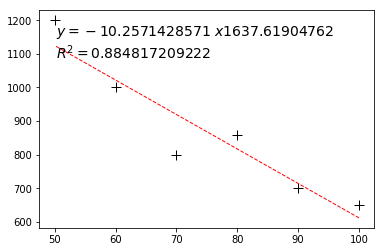